In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import polars as pl
import numpy as np
import logging
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb 
import xgboost as xgb 

# --- Kaggle Evaluation API Interface (Mandatory) ---
try:
    import kaggle_evaluation.default_inference_server as inference_server
except ImportError:
    # Mock definitions for local testing environment
    class MockInferenceServer:
        def __init__(self, predict_fn):
            self.predict_fn = predict_fn
        def serve(self):
            logging.info("Mock Inference Server Running...")
        def run_local_gateway(self, path):
            logging.info(f"Mock Local Gateway Running with path: {path}")
    inference_server = MockInferenceServer

# --- Global Model Variables ---
MODEL_LGBM = None
MODEL_XGB = None
TRAIN_COLS = None
TRAIN_MEANS = None

logging.basicConfig(level=logging.INFO)

# --- Feature Engineering and Selection (Simplified) ---

def preprocess_data(df: pl.DataFrame, is_training: bool = False) -> pd.DataFrame:
    """
    Standard preprocessing for the financial time series data, now simplified 
    to reduce overfitting from overly long-range features.
    """
    
    # --- Polars Feature Engineering (Time Series Features) ---
    
    if 'date_id' in df.columns:
        df = df.with_columns(
            (pl.col('date_id') % 5).alias('day_of_cycle') # Proxy for Day-of-Week
        )
    
    # REDUCTION: Only use shorter, more relevant rolling windows
    ROLLING_WINDOWS = [5, 10]
    BASE_FEATURES = ['M1', 'E1', 'V1', 'S1', 'T1', 'P1', 'D1']

    expressions = []
    
    # Simple Lag Features for Momentum
    LAG_WINDOWS = [1, 5]
    for lag in LAG_WINDOWS:
        for col in BASE_FEATURES:
            if col in df.columns:
                expressions.append(
                    pl.col(col).shift(lag).alias(f'{col}_lag_{lag}')
                )
    
    # Rolling Mean and Std Dev Features
    for window in ROLLING_WINDOWS:
        for col in BASE_FEATURES:
            if col in df.columns:
                expressions.append(
                    pl.col(col).rolling_mean(window_size=window, min_samples=1).alias(f'{col}_roll_mean_{window}')
                )
                expressions.append(
                    pl.col(col).rolling_std(window_size=window, min_samples=1).alias(f'{col}_roll_std_{window}')
                )
    
    if expressions:
        df = df.with_columns(expressions)
        
    # --- Convert to Pandas and create Interaction and EMA Features ---
    pdf = df.to_pandas()
    
    # REDUCTION: Only use shorter EMAs
    EMA_WINDOWS = [10, 30] 
    for window in EMA_WINDOWS:
        for col in BASE_FEATURES:
            if col in pdf.columns:
                pdf[f'{col}_ema_{window}'] = pdf[col].ewm(span=window, adjust=False).mean()
    
    # Interaction Features (Ratios and Differences) - Kept
    FEATURE_PAIRS = [('M1', 'M2'), ('E1', 'E2'), ('V1', 'V2'),
                     ('S1', 'S2'), ('T1', 'T2'), ('P1', 'P2'), ('D1', 'D2')]

    for col1, col2 in FEATURE_PAIRS:
        if col1 in pdf.columns and col2 in pdf.columns:
            pdf[f'{col1}_div_{col2}'] = pdf[col1] / (pdf[col2].replace(0, 1e-6) + 1e-6)
            pdf[f'{col1}_minus_{col2}'] = pdf[col1] - pdf[col2]
            
    # Quadratic Features (Non-Linearity) - Kept
    for col in BASE_FEATURES:
        if col in pdf.columns:
            pdf[f'{col}_sq'] = pdf[col] ** 2

    # Drop non-feature columns
    EXCLUDE_FINAL_COLS = ['date_id', 'forward_returns', 'risk_free_rate',
                          'market_forward_excess_returns', 'is_scored',
                          'lagged_forward_returns', 'lagged_risk_free_rate',
                          'lagged_market_forward_excess_returns']
                          
    final_cols = [col for col in pdf.columns if col not in EXCLUDE_FINAL_COLS]
    
    return pdf[final_cols]

# --- Core Prediction and Allocation Logic ---

def train_model(train_df: pl.DataFrame):
    """
    Trains a LightGBM and an XGBoost model with enhanced regularization.
    """
    global MODEL_LGBM, MODEL_XGB, TRAIN_COLS, TRAIN_MEANS
    
    # Target is binary: Predict 1 if the return is positive, 0 otherwise.
    y_train = (train_df['market_forward_excess_returns'].to_numpy() > 0).astype(int)
    
    # Prepare Features
    X_train_pd = preprocess_data(train_df, is_training=True)
    
    TRAIN_COLS = list(X_train_pd.columns)
    
    # Impute Data Manually
    TRAIN_MEANS = X_train_pd.mean()
    X_train_pd = X_train_pd.fillna(TRAIN_MEANS)

    # --- 1. LightGBM Model Training (Increased Regularization) ---
    regressor_lgbm = lgb.LGBMClassifier( 
        objective='binary',
        n_estimators=3500,             
        learning_rate=0.01,            
        num_leaves=127,                # REDUCED complexity (was 255)
        subsample=0.8,                
        colsample_bytree=0.8,         
        random_state=42,
        n_jobs=4,
        reg_lambda=3.0,                # INCREASED L2 regularization (was 2.0)
        reg_alpha=0.5,                 # INCREASED L1 regularization (was 0.3)
        min_child_samples=20,          
        boosting_type='gbdt'
    )
    logging.info("Starting LightGBM training...")
    regressor_lgbm.fit(X_train_pd, y_train)
    MODEL_LGBM = regressor_lgbm
    logging.info("LightGBM training complete.")

    # --- 2. XGBoost Model Training (Increased Regularization) ---
    regressor_xgb = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=3000,             
        learning_rate=0.01,
        max_depth=7,                   # REDUCED tree depth (was 9)
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.2,                     
        reg_lambda=3.0,                # INCREASED L2 regularization (was 2.0)
        reg_alpha=0.5,                 # INCREASED L1 regularization (was 0.3)
        random_state=42,
        n_jobs=4,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    logging.info("Starting XGBoost training...")
    regressor_xgb.fit(X_train_pd, y_train)
    MODEL_XGB = regressor_xgb
    logging.info("XGBoost training complete.")

def convert_prediction_to_allocation(predicted_probability: float) -> float:
    """
    Converts the model's predicted probability of a positive return (P)
    into the required allocation size (0.0 to 2.0).
    
    Multiplier is reduced for lower risk.
    """
    
    CONFIDENCE_MULTIPLIER = 3.0 # REDUCED from 4.0 for less aggressive betting

    # 1. Calculate the 'Edge' or deviation from neutral (0.5)
    edge = predicted_probability - 0.5
    
    # 2. Apply the Tanh scaling. 
    scaled_edge = np.tanh(CONFIDENCE_MULTIPLIER * edge)
    
    # 3. Map the scaled edge back to the final allocation range [0.0, 2.0]
    final_allocation = 1.0 + scaled_edge
    
    # Clip the result to the required range [0.0, 2.0]
    final_allocation = np.clip(final_allocation, 0.0, 2.0)
    
    return float(final_allocation)

# --- The Required Kaggle Inference Function ---

def predict(test: pl.DataFrame) -> float:
    """
    The main inference function called by the Kaggle evaluation API.
    Calculates predictions from both LGBM and XGBoost and uses a 60/40 blend.
    """
    global MODEL_LGBM, MODEL_XGB, TRAIN_COLS, TRAIN_MEANS
    
    is_mock_run = not os.getenv('KAGGLE_IS_COMPETITION_RERUN')
    default_return = (1.0, 0.5) if is_mock_run else 1.0
    
    if MODEL_LGBM is None or MODEL_XGB is None:
        # Load the full training set for the very first call to train the model
        train_path = os.path.expanduser('~/Documents/kaggle/hull_tactical/data/train.csv')
        
        try:
            train_df = pl.read_csv(train_path, try_parse_dates=True, infer_schema_length=100000)
        except Exception as e:
            logging.error(f"Could not load train.csv: {e}. Returning neutral allocation.")
            return default_return

        train_model(train_df)
        
        if MODEL_LGBM is None or MODEL_XGB is None:
            logging.error("Model training failed. Returning neutral allocation.")
            return default_return

    # Ensure we only use the features the models were trained on
    try:
        # Preprocess the test data to create the same interaction features
        X_test_pd = preprocess_data(test)
        
        # Identify missing features and fill with NaN
        missing_cols = set(TRAIN_COLS) - set(X_test_pd.columns)
        for col in missing_cols:
            X_test_pd[col] = np.nan
            
        X_test_pd = X_test_pd[TRAIN_COLS] # Reorder and select
        
        # IMPUTATION STEP: using TRAIN_MEANS
        if TRAIN_MEANS is not None:
              X_test_pd = X_test_pd.fillna(TRAIN_MEANS)
        else:
              X_test_pd = X_test_pd.fillna(X_test_pd.mean())
        
    except Exception as e:
        logging.error(f"Feature selection failed in predict: {e}")
        return default_return

    # Predict the probability of positive excess return (P(return > 0))
    try:
        # Get individual model predictions
        p_lgbm = MODEL_LGBM.predict_proba(X_test_pd)[-1, 1]
        p_xgb = MODEL_XGB.predict_proba(X_test_pd)[-1, 1]

        # --- ENSEMBLE BLEND (60/40 Average) ---
        # Giving 60% weight to the more stable LGBM model
        p_positive_blended = (0.6 * p_lgbm) + (0.4 * p_xgb)
        
        # Convert blended prediction into the final allocation
        final_allocation = convert_prediction_to_allocation(p_positive_blended)
        
        # Return the allocation (and probability for mock testing)
        if is_mock_run:
              return (final_allocation, p_positive_blended)
        
        return final_allocation

    except Exception as e:
        logging.error(f"Inference failed: {e}. Returning neutral allocation.")
        return default_return

# --- Visualization Helper ---
def plot_results(results_df: pd.DataFrame):
    """Generates a plot of the predicted returns and allocations."""
    
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Predicted Probability (left axis)
    color = 'tab:blue'
    ax1.set_xlabel('Simulated Day')
    ax1.set_ylabel('Blended Predicted Probability (P > 0)', color=color)
    ax1.plot(results_df['day'], results_df['predicted_return'], color=color, label='Blended P(Up)', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.axhline(0.5, color='orange', linestyle='--', label='Neutral P(0.5)')

    # Plot Allocation (right axis)
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Final Allocation (0.0 to 2.0)', color=color)  
    ax2.plot(results_df['day'], results_df['allocation'], color=color, label='Final Allocation', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(1.0, color='gray', linestyle=':', label='Neutral (1.0)')

    # Title and Final Touches
    fig.suptitle('Robust LGBM (60%) + XGBoost (40%) Ensemble Mock Prediction')
    fig.tight_layout()
    plt.show()

# --- Mock Test Runner ---
def run_mock_test_and_visualize():
    """Simulates 50 days of inference for visualization."""
    
    # Features used for the mock test
    MOCK_FEATURES = [
        'D1', 'D2', 'E1', 'E2', 'V1', 'V2', 'S1', 'S2', 'M1', 'M2', 'T1', 'T2', 'P1', 'P2'
    ]
    
    results = []
    
    # 1. Simulate training (call predict once)
    mock_data_init = {col: [np.random.rand()] for col in MOCK_FEATURES}
    mock_data_init['market_forward_excess_returns'] = [np.random.uniform(-0.01, 0.01)]
    mock_data_init['date_id'] = [1000]
    mock_test_df_init = pl.DataFrame(mock_data_init)
    
    logging.info("Starting initial predict call (triggers LGBM + XGBoost training simulation)...")
    
    # Call predict() to trigger model training. We discard the first result.
    _ = predict(mock_test_df_init)
    logging.info("Ensemble models are now trained and ready for inference.")

    # 2. Simulate 50 days of real-time inference
    NUM_SIMULATION_DAYS = 50
    for day in range(NUM_SIMULATION_DAYS):
        # Generate random feature values for the day
        mock_day_data = {
            c: [np.random.uniform(0.1, 0.9) if c == 'M1' else np.random.rand()]
            for c in MOCK_FEATURES
        }
        mock_day_data['market_forward_excess_returns'] = [np.random.uniform(-0.01, 0.01)]
        mock_day_data['date_id'] = [1001 + day]
        mock_test_df_day = pl.DataFrame(mock_day_data)
        
        # Predict returns the tuple (allocation, raw_prediction) in mock mode
        allocation, p_positive_blended = predict(mock_test_df_day)
        
        results.append({
            'day': day + 1,
            'predicted_return': p_positive_blended, # Storing blended probability here
            'allocation': allocation
        })

    # 3. Process and Plot Results
    results_df = pd.DataFrame(results)
    
    logging.info(f"\n--- MOCK TEST SIMULATION SUMMARY (50 Days) ---")
    logging.info(f"Mean Blended Predicted Probability (P > 0): {results_df['predicted_return'].mean():.6f}")
    logging.info(f"Mean Final Allocation: {results_df['allocation'].mean():.4f}")
    logging.info(f"Min/Max Allocation: {results_df['allocation'].min():.4f} / {results_df['allocation'].max():.4f}")
    logging.info("-------------------------------------------------")
    
    # Print the plot output (this will render the visualization)
    plot_results(results_df)



In [17]:
import os
import polars as pl
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import xgboost as xgb

def strategy_sharpe(y_true, allocation):
    # allocation in [0, 2]; realized return = allocation * excess_return
    r = allocation * y_true
    return np.mean(r) / (np.std(r) + 1e-9)

# Load and preprocess data
train_path = os.path.expanduser('~/Documents/kaggle/hull_tactical/data/train.csv')
train_df = pl.read_csv(train_path, try_parse_dates=True, infer_schema_length=100000)
train_df = train_df.with_columns(pl.all().exclude('date_id').cast(pl.Float64, strict=False))

y = train_df['market_forward_excess_returns'].to_numpy()
X_pd = preprocess_data(train_df, is_training=True).fillna(0)  # uses your existing function

tscv = TimeSeriesSplit(n_splits=5)
scores = []

for i, (train_idx, val_idx) in enumerate(tscv.split(X_pd)):
    X_train, X_val = X_pd.iloc[train_idx], X_pd.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Binary target for classifiers
    y_train_bin = (y_train > 0).astype(int)

    # --- LightGBM ---
    model_lgbm = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=1500,
        learning_rate=0.01,
        num_leaves=127,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        reg_lambda=3.0,
        reg_alpha=0.5,
        min_child_samples=20,
    )
    model_lgbm.fit(X_train, y_train_bin)

    # --- XGBoost ---
    model_xgb = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=1200,
        learning_rate=0.01,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.2,
        reg_lambda=3.0,
        reg_alpha=0.5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
    )
    model_xgb.fit(X_train, y_train_bin)

    # Blend predictions (probability of positive return)
    p_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    p_xgb  = model_xgb.predict_proba(X_val)[:, 1]
    p_blend = 0.6 * p_lgbm + 0.4 * p_xgb

    # Convert blended probability to allocation in [0, 2]
    allocation = 1.0 + np.tanh(3.0 * (p_blend - 0.5))
    allocation = np.clip(allocation, 0.0, 2.0)

    # Use strategy Sharpe (allocation * excess_return)
    score = strategy_sharpe(y_val, allocation)
    scores.append(score)
    print(f"Fold {i+1} Strategy-Sharpe: {score:.6f}")

print("Average Strategy-Sharpe CV:", np.mean(scores))

[LightGBM] [Info] Number of positive: 751, number of negative: 755
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12770
[LightGBM] [Info] Number of data points in the train set: 1506, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498672 -> initscore=-0.005312
[LightGBM] [Info] Start training from score -0.005312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/home/wes/Documents/kaggle/hull_tactical/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:20:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1 Strategy-Sharpe: 0.021888
[LightGBM] [Info] Number of positive: 1509, number of negative: 1500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26203
[LightGBM] [Info] Number of data points in the train set: 3009, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501496 -> initscore=0.005982
[LightGBM] [Info] Start training from score 0.005982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

/home/wes/Documents/kaggle/hull_tactical/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:20:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 Strategy-Sharpe: -0.010991
[LightGBM] [Info] Number of positive: 2288, number of negative: 2224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30199
[LightGBM] [Info] Number of data points in the train set: 4512, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507092 -> initscore=0.028371
[LightGBM] [Info] Start training from score 0.028371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/wes/Documents/kaggle/hull_tactical/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3 Strategy-Sharpe: 0.018340
[LightGBM] [Info] Number of positive: 3089, number of negative: 2926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33958
[LightGBM] [Info] Number of data points in the train set: 6015, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513549 -> initscore=0.054211
[LightGBM] [Info] Start training from score 0.054211


/home/wes/Documents/kaggle/hull_tactical/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:20:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 Strategy-Sharpe: 0.030593
[LightGBM] [Info] Number of positive: 3868, number of negative: 3650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36030
[LightGBM] [Info] Number of data points in the train set: 7518, number of used features: 160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514499 -> initscore=0.058010
[LightGBM] [Info] Start training from score 0.058010


/home/wes/Documents/kaggle/hull_tactical/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:21:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5 Strategy-Sharpe: 0.027076
Average Strategy-Sharpe CV: 0.017381254790062316


In [4]:
# # --- Main Execution Block for Kaggle ---

# # The DefaultInferenceServer handles the time-series API interaction. 
# inference_server_instance = inference_server.DefaultInferenceServer(predict)

# # Run the server logic based on the environment
# if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
#     inference_server_instance.serve()
# else:
#     logging.info("Running local gateway for testing.")
#     try:
#         local_input_path = os.path.join(os.getcwd(), 'kaggle_input/hull-tactical-market-prediction/')
#         inference_server_instance.run_local_gateway((local_input_path,))
#     except Exception as e:
#         logging.error(f"Local gateway simulation failed. This is expected outside Kaggle: {e}")
        
#         # Run the expanded mock test and visualization
#         run_mock_test_and_visualize()
        
#         # --- Mandatory Dummy Submission File Generation for Kaggle System Check ---
#         logging.info("Generating dummy submission.parquet for Kaggle system check.")
        
#         dummy_submission = pl.DataFrame({
#             'date_id': [999], 
#             'allocation': [1.0]
#         })
#         dummy_submission.write_parquet('submission.parquet')
#         logging.info("submission.parquet created successfully.")


In [5]:
import polars as pl
from pathlib import Path

DATA_PATH = Path.home() / "Documents/kaggle/hull_tactical/data"

train = pl.read_csv(DATA_PATH / "train.csv")
test  = pl.read_csv(DATA_PATH / "test.csv")

print(train.shape, test.shape)
print(train.columns[:20])
train.head(5)


(9021, 98) (10, 99)
['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18']


date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64
0,0,0,0,1,1,0,0,0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.002421,0.000301,-0.003038
1,0,0,0,1,1,0,0,0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.008495,0.000303,-0.009114
2,0,0,0,1,0,0,0,0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.009624,0.000301,-0.010243
3,0,0,0,1,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.004662,0.000299,0.004046
4,0,0,0,1,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.011686,0.000299,-0.012301


In [6]:
# Cast all non-date columns to float where possible
train = train.with_columns(
    pl.all().exclude("date_id").cast(pl.Float64, strict=False)
)

# confirm types
train.dtypes[:10]

[Int64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64]

In [7]:
train.head(3)

date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,…,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.002421,0.000301,-0.003038
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.008495,0.000303,-0.009114
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-0.009624,0.000301,-0.010243


In [8]:
import polars as pl

null_counts = (
    train
    .select(pl.all().null_count())                                 # one-row DF of counts
    .transpose(include_header=True, header_name="column", column_names=["nulls"])
    .sort("nulls", descending=True)
)

null_counts.head(20)

column,nulls
str,u32
"""E7""",6969
"""V10""",6049
"""S3""",5733
"""M1""",5547
"""M13""",5540
…,…
"""E20""",1616
"""P7""",1616
"""P5""",1574


In [9]:
import polars as pl

N = train.height
THRESH = int(0.5 * N)  # drop columns with >50% nulls

# 1) null counts as Series
nc = (
    train
    .select(pl.all().null_count())
    .transpose(include_header=True, header_name="column", column_names=["nulls"])
)

# 2) keep/drop lists
to_keep = nc.filter(pl.col("nulls") <= THRESH)["column"].to_list()
to_drop = nc.filter(pl.col("nulls") > THRESH)["column"].to_list()

# 3) always keep these even if nully (index/targets)
ALWAYS_KEEP = {"date_id", "market_forward_excess_returns"}
to_keep = list(sorted(set(to_keep).union(ALWAYS_KEEP)))
to_drop = [c for c in to_drop if c not in ALWAYS_KEEP]

print(f"keep: {len(to_keep)} cols | drop: {len(to_drop)} cols")
# peek which got dropped
to_drop[:15]

keep: 90 cols | drop: 8 cols


['E7', 'M1', 'M13', 'M14', 'M6', 'S3', 'V10', 'V9']

In [10]:
train_filled = train.select([
    pl.when(pl.col(c).is_null())
    .then(pl.col(c).mean())
    .otherwise(pl.col(c))
    .cast(pl.Float64)
    .alias(c)
    for c in to_keep
])

In [11]:
train_filled.dtypes[:10]
train_filled.null_count().sum()
train_filled.head(3)

D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,…,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S4,S5,S6,S7,S8,S9,V1,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,date_id,forward_returns,market_forward_excess_returns,risk_free_rate
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.564376,0.503676,0.125415,0.118313,0.012279,0.006991,0.486758,-0.047978,-0.009339,0.098024,0.116761,0.504014,0.90539,0.346242,0.016857,0.598541,0.122023,-0.272228,0.26591,0.74532,-0.522922,0.607538,0.551064,0.186341,0.456389,0.706785,0.572773,0.187819,…,1.260329,-0.020481,0.508742,-0.36495,0.495414,0.500406,0.001178,0.052918,0.249174,1.543061,0.393674,0.241018,0.437959,0.432863,0.265411,0.025082,0.456036,0.034151,0.515287,0.494731,0.079207,0.456539,0.325772,0.230551,0.253973,0.111299,0.50896,0.489076,0.506589,0.373584,0.288874,0.145886,0.303203,0.0,-0.002421,-0.003038,0.000301
0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.564376,0.503676,0.125415,0.118313,0.012279,0.006991,0.486758,-0.047978,-0.009339,0.098024,0.116761,0.504014,0.90539,0.346242,0.016857,0.598541,0.122023,-0.272228,0.26591,0.74532,-0.522922,0.607538,0.551064,0.186341,0.456389,0.706785,0.572773,0.187819,…,1.260329,-0.020481,0.508742,-0.36495,0.495414,0.500406,0.001178,0.052918,0.249174,1.543061,0.393674,0.241018,0.437959,0.432863,0.265411,0.025082,0.456036,0.034151,0.515287,0.494731,0.079207,0.456539,0.325772,0.230551,0.253973,0.111299,0.50896,0.489076,0.506589,0.373584,0.288874,0.145886,0.303203,1.0,-0.008495,-0.009114,0.000303
0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.564376,0.503676,0.125415,0.118313,0.012279,0.006991,0.486758,-0.047978,-0.009339,0.098024,0.116761,0.504014,0.90539,0.346242,0.016857,0.598541,0.122023,-0.272228,0.26591,0.74532,-0.522922,0.607538,0.551064,0.186341,0.456389,0.706785,0.572773,0.187819,…,1.260329,-0.020481,0.508742,-0.36495,0.495414,0.500406,0.001178,0.052918,0.249174,1.543061,0.393674,0.241018,0.437959,0.432863,0.265411,0.025082,0.456036,0.034151,0.515287,0.494731,0.079207,0.456539,0.325772,0.230551,0.253973,0.111299,0.50896,0.489076,0.506589,0.373584,0.288874,0.145886,0.303203,2.0,-0.009624,-0.010243,0.000301


In [12]:
train.select([
    pl.col("market_forward_excess_returns").mean().alias("mean"),
    pl.col("market_forward_excess_returns").std().alias("std"),
    pl.col("market_forward_excess_returns").min().alias("min"),
    pl.col("market_forward_excess_returns").max().alias("max"),
])

mean,std,min,max
f64,f64,f64,f64
0.000053,0.010558,-0.040582,0.040551


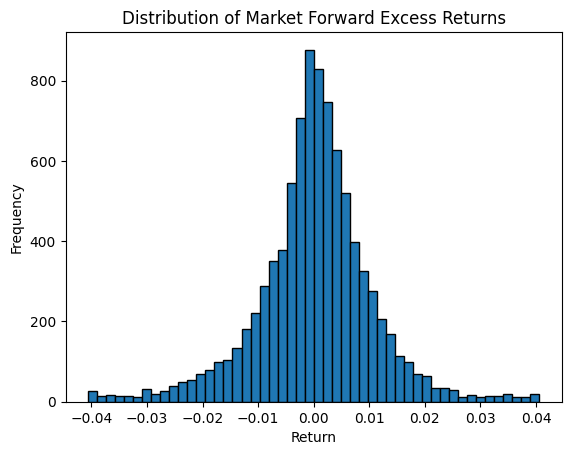

In [13]:
import matplotlib.pyplot as plt

plt.hist(
    train_filled["market_forward_excess_returns"].to_numpy(),
    bins=50,
    edgecolor="black"
)
plt.title("Distribution of Market Forward Excess Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

In [14]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

y = train["market_forward_excess_returns"].to_numpy()
X = train.drop(["market_forward_excess_returns"]).to_pandas()

# Fill any remaining NaNs
X = X.fillna(X.mean())

tscv = TimeSeriesSplit(n_splits=5)

for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"Fold {i+1}: train={train_idx[0]}–{train_idx[-1]}, val={val_idx[0]}–{val_idx[-1]}")

Fold 1: train=0–1505, val=1506–3008
Fold 2: train=0–3008, val=3009–4511
Fold 3: train=0–4511, val=4512–6014
Fold 4: train=0–6014, val=6015–7517
Fold 5: train=0–7517, val=7518–9020


In [15]:
def sharpe_like(y_true, y_pred):
    r = y_pred - y_true
    return np.mean(r) / (np.std(r) + 1e-9)

mean_pred = np.full_like(y, y.mean())

scores = []
for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    y_val = y[val_idx]
    y_pred = mean_pred[val_idx]
    score = sharpe_like(y_val, y_pred)
    scores.append(score)
    print(f"Fold {i+1} Sharpe-like: {score:.6f}")

print("Average Sharpe-like CV:", np.mean(scores))

Fold 1 Sharpe-like: -0.000347
Fold 2 Sharpe-like: 0.024497
Fold 3 Sharpe-like: -0.000565
Fold 4 Sharpe-like: -0.009725
Fold 5 Sharpe-like: -0.018547
Average Sharpe-like CV: -0.0009372756983632959


In [16]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=100000)

scores = []
for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    enet.fit(X_train, y_train)
    y_pred = enet.predict(X_val)
    score = sharpe_like(y_val, y_pred)
    scores.append(score)
    print(f"Fold {i+1} Sharpe-like: {score:.6f}")

print("Average Sharpe-like CV:", np.mean(scores))

Fold 1 Sharpe-like: 0.065606
Fold 2 Sharpe-like: -0.029033
Fold 3 Sharpe-like: -0.019255
Fold 4 Sharpe-like: -0.015440
Fold 5 Sharpe-like: -0.004284
Average Sharpe-like CV: -0.0004813410397651619
